In [1]:
import tensorflow as tf
import tensorflow.keras as kr
import keras
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt
import math as mth
import random as random

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM

from keras.optimizers import RMSprop

Using TensorFlow backend.


In [296]:
#DECLARACION DE CLASES
#Los vectores de 8 elementos se llaman "pixels" porque son un conjunto de elementos "pixel"
#Voy a generar un vector "dataset" que es un vector de 10000 elemenos de tipo "pixels"

class pixel:
    #esta es la clase pixel, contiene tres canales de enteros de rango 0 a 255 cada uno
    #por una cuestion de entendimiento los canales se van a llamar R,G y B pero no tiene nada que ver con los colores en si,
    #son solo numeros
    def __init__(self,tiempo, a=0, b=0,A=127,frecR = 0.05,frecG = 2, frecB = 5):
        self.R = mth.floor((A * mth.sin(frecR*tiempo + a)) + (A+1) + b)#Aqui genero los tres canales del pixel
        self.G = mth.floor((A * mth.sin(frecG*tiempo + a)) + (A+1) + b)
        self.B = mth.floor((A * mth.sin(frecB*tiempo + a)) + (A+1) + b)
        #Esto se hace para que los valores sigan dentro del rango 0-255 :
        if self.R > 255: 
            self.R = 255
        if self.G > 255: 
            self.G = 255
        if self.B > 255: 
            self.B = 255
        if self.R < 0: 
            self.R = 0
        if self.G < 0: 
            self.G = 0
        if self.B < 0: 
            self.B = 0
    def getData(self): #Esto es para visualizar rapido en caso de que sea necesario
        print("R:",self.R, "G:",self.G, "B:", self.B)
        
class pixels(list): #Esta es la clase de 8 elementos (cada elemento es un pixel)
    def fillWithPixels(self, frecR = 0.05 ,b=0,cantElementos = 8):
        a = mth.floor(random.uniform(0,10)) #Aqui esta la aleatoriedad necesaria para entrenar bien
        for x in range(cantElementos*5):
            #print("Iteracion numero ", x)
            if(x % 5 == 0):
                self.append(pixel(x,a,b,127,frecR))

In [78]:
#prueba:
X = pixels()
X.fillWithPixels()
X[0].getData()
X[1].getData()
X[2].getData()
X[3].getData()
X[4].getData()
X[5].getData()
X[6].getData()
X[7].getData()

R: 180 G: 180 B: 180
R: 150 G: 147 B: 195
R: 118 G: 43 B: 208
R: 87 G: 250 B: 221
R: 58 G: 6 B: 231
R: 34 G: 208 B: 240
R: 16 G: 113 B: 247
R: 4 G: 71 B: 252


In [298]:
#GENERACION DEL DATASET DE ENTRENAMIENTO
#Quiero una lista de 10000 elementos. Cada elemento es un vector de pixels. Es decir dataset1 y dataset2 son listas de 10000 elementos de pixels.
#Cada uno de ellos es un conjunto de 8 elementos pixel

size = 10000
dataset1 = [] #Para entrenamiento
dataset2 = [] #Para testeo

for x in range(size): 
    dataset1.append(pixels())
    dataset1[x].fillWithPixels()
    dataset2.append(pixels())
    dataset2[x].fillWithPixels()

    
#prueba de que anda todo bien hasta aqui:

dataset1[258][4].getData()

R: 180 G: 30 B: 245


In [299]:
#PREPARACION DEL DATASET PARA ENTRENAMIENTO
#Aqui voy a preparar el dataset para que sea compatible con la red y pueda ser usado para entrenarla:
#Tengo que convertir todo a tensores con la libreria numpy

#La idea de este notebook es quedarse solo con los ROJOS:

dataset1_np = np.array(dataset1)
dataset2_np = np.array(dataset2)


#Estas asignaciones son para decirle a r_train y a r_test EL TAMAÑO QUE DEBEN TENER
#Debe haber una forma mas feliz de hacer esto pero no la descubri y si saco estas lineas me tira error
#------------------------------------inicio de solucion momentanea------------------------------------------
r_train = np.array(dataset1_np)
r_test = np.array(dataset1_np)
ry_train = np.zeros(10000)
ry_test = np.zeros(10000)
rx_train = np.zeros((10000,7))
rx_test = np.zeros((10000,7))
#----------------------------------------fin de solucion momentanea--------------------------------------------

k = 0

#Con esto lo que hago es hacer que r_train y r_test tengan todos los datos ROJOS. Luego, rx_train y tx_test tienen los 
#datos de rojos correspondientes a los primeros 7 elementos que son la entrada a la red.
#Luego, ry_train y ry_test tienen los 8vos elementos que son la salida de la red

for i in range(10000):
    for j in range (8):
        r_train[i][j] = dataset1_np[i][j].R
        r_test[i][j] = dataset2_np[i][j].R
        if j == 7:
            ry_train[k] = r_train[i][j] #La salida de la red neuronal es el ULTIMO elemento de un pixels (o sea T = 7) Eso es lo que quiero predecir
            ry_test[k] = r_test[i][j]
            k = k + 1
            
for i in range(10000):
    for j in range (8):
        if j != 7:
            rx_train[i][j] = r_train[i][j]
            rx_test[i][j] = r_test[i][j]

            
rx_train = rx_train.reshape((10000,7,1)) #estos reshapes son necesarios, aunque a veces me olvido por que
rx_test = rx_test.reshape((10000,7,1))

#Y listo, con eso vamos a entrenar la red para UN SOLO CANAL. Mas adelante hay que hacerlo andar con los 3 canales.
#Para eso va a haber que hacer algo asi: (pero todavia no lo hice andar)


#x_train = np.array(dataset1)
#y_train = x_train


#x_test = np.array(dataset2)
#y_test = x_test

In [94]:
rx_train[4]

array([[145.],
       [114.],
       [ 83.],
       [ 55.],
       [ 31.],
       [ 14.],
       [  3.]])

In [88]:
#DEFINICION DE ARQUITECTURA DE RED NEURONAL - SEGUNDO INTENTO (el primer intento fue deleteado)

#input_dim = 256 #es el numero de entrada posible mas grande + 1, segun documentacion de keras
#model = Sequential() #Creo la red neuronal
#model.add(Embedding(input_dim, output_dim=64, input_length=7)) #Agrego la capa embedding. Suele ser la primer capa de un red en keras, siempre.

#model.add(LSTM(128))
# el argumento return_sequences=True en la capa LSTM, devuelve una secuencia completa
# si no lo pones, te liberas de la variable temporal. Cuando hay varias capas LSTM, en general la ultima lo tiene como false

#model.add(Dropout(0.5)) #Agrego capa de Dropout
#model.add(Dense(64, activation='relu'))
#model.add(Dense(1, activation='relu'))

In [301]:
#DEFINICION DE ARQUITECTURA DE RED NEURONAL - TERCER INTENTO

model = Sequential() #Creo la red neuronal
#input_dim = 256 #es el numero de entrada posible mas grande + 1, segun documentacion de keras
#model.add(Embedding(input_dim, output_dim=256, input_length=7)) #Agrego la capa embedding. Suele ser la primer capa de un red en keras, siempre.
model.add(LSTM(200, activation='relu', input_shape=(7,1))) #7 entradas de 1 caracteristica cada una. Cuando agregue los azules
#y rojos, en vez de 1 va a ser 3


model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5)) #Agrego capa de Dropout
model.add(Dense(1, activation='relu'))

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [302]:
#COMPILACION DE LA RED


optimizador = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
#optimizador = keras.optimizers.Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
model.compile(loss='mean_squared_error',
              optimizer=optimizador,
              metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_8 (LSTM)                (None, 200)               161600    
_________________________________________________________________
dense_15 (Dense)             (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 101       
Total params: 181,801
Trainable params: 181,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#ENTRENAMIENTO DE LA RED
#model.fit(r_train, r_train, batch_size=1000, epochs=100)
history = model.fit(rx_train, ry_train, validation_data=(rx_test, ry_test) ,epochs=20)
# model.save_weights('first_try.h5') # 26% de accuracy pero mal implementada la red
# model.save_weights('second_try.h5') # 4.74% de accuracy, mejor implementada
#model.save_weights('third_try.h5') #
#model.save('tercer_intento') #84 % de accuracy en el train y 30% en el test. Tremendo Overfitting
#model.save_weights('fourth_try.h5') #50% en el train y 40% en el test. Parece poco pero en realidad es muy buen accuracy
#model.save('cuarto_intento')
model.save_weights('fifth_try.h5') #el modelo es igual al cuarto intento pero activando la capa de DropOut
model.save('quinto_intento')
score = model.evaluate(rx_test, ry_test)
score

Train on 10000 samples, validate on 10000 samples
Epoch 1/20
10000/10000 [==============================] - 7s 693us/step - loss: 494.5450 - acc: 0.1578 - val_loss: 146.3532 - val_acc: 0.2029
Epoch 2/20
10000/10000 [==============================] - 7s 719us/step - loss: 486.1539 - acc: 0.1603 - val_loss: 13.0191 - val_acc: 0.3987
Epoch 3/20
10000/10000 [==============================] - 7s 725us/step - loss: 490.6040 - acc: 0.1533 - val_loss: 66.6415 - val_acc: 0.2029
Epoch 4/20
10000/10000 [==============================] - 7s 716us/step - loss: 490.9005 - acc: 0.1645 - val_loss: 2.4524 - val_acc: 0.2029
Epoch 5/20
10000/10000 [==============================] - 7s 697us/step - loss: 495.4485 - acc: 0.1634 - val_loss: 14.2516 - val_acc: 0.2017
Epoch 6/20
10000/10000 [==============================] - 8s 758us/step - loss: 474.9265 - acc: 0.1692 - val_loss: 20.7459 - val_acc: 0.2994
Epoch 7/20
10000/10000 [==============================] - 7s 714us/step - loss: 469.2609 - acc: 0.1725 -

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])


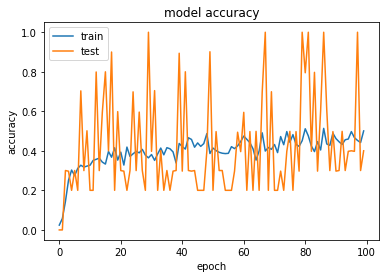

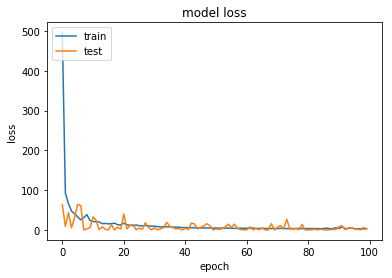

In [304]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [201]:
#AHORA PRUEBO CON VALORES FUERA DEL DATASET DE TRAINING
#(correr este bloque repetidas veces y verificar que la prediccion y el valor verdadero se parecen)

X = pixels()
X.fillWithPixels()
Z = [0,0,0,0,0,0,0,0]
Z[0] = X[0].R
Z[1] = X[1].R
Z[2] = X[2].R
Z[3] = X[3].R
Z[4] = X[4].R
Z[5] = X[5].R
Z[6] = X[6].R
Z[7] = X[7].R
entrada = np.array([Z[0],Z[1],Z[2],Z[3],Z[4],Z[5],Z[6]])
entrada = entrada.reshape(1,7,1)
Y = np.round(model.predict(entrada))
print("prediccion: ",Y)
print("valor posta: ",Z[7])

prediccion:  [[4.]]
valor posta:  4


In [293]:
#AHORA PRUEBO CON UNA SENOIDAL QUE TENGA UNA ALTURA DIFERENTE A 0 (o sea que sature)
#(sigue teniendo una accuracy bastante aceptable)
#(y eso que en el dataset b era 0 siempre)

X = pixels()
X.fillWithPixels(0.05,40)
Z = [0,0,0,0,0,0,0,0]
Z[0] = X[0].R
Z[1] = X[1].R
Z[2] = X[2].R
Z[3] = X[3].R
Z[4] = X[4].R
Z[5] = X[5].R
Z[6] = X[6].R
Z[7] = X[7].R
entrada = np.array([Z[0],Z[1],Z[2],Z[3],Z[4],Z[5],Z[6]])
entrada = entrada.reshape(1,7,1)
Y = np.round(model.predict(entrada))
print("prediccion: ",Y)
print("valor posta: ",Z[7])

prediccion:  [[91.]]
valor posta:  95


In [225]:
#AHORA PRUEBO CON UNA SENOIDAL QUE TENGA UNA FRECUENCIA DIFERENTE
#(el desempeño es espantosamente malo)
#(lo cual es logico, la frecuencia era siempre 0.05 en el dataset)
#(pienso que podría agrandar el dataset, poniendo varias frecuencias y/o cambiar la topología de la red)
#(pero eso lo voy a hacer en la red ubicada en la carpeta "Second")

X = pixels()
X.fillWithPixels(0.2)
Z = [0,0,0,0,0,0,0,0]
Z[0] = X[0].R
Z[1] = X[1].R
Z[2] = X[2].R
Z[3] = X[3].R
Z[4] = X[4].R
Z[5] = X[5].R
Z[6] = X[6].R
Z[7] = X[7].R
entrada = np.array([Z[0],Z[1],Z[2],Z[3],Z[4],Z[5],Z[6]])
entrada = entrada.reshape(1,7,1)
Y = np.round(model.predict(entrada))
print("prediccion: ",Y)
print("valor posta: ",Z[7])

prediccion:  [[124.]]
valor posta:  253
